# Using VARMAX on Stock Prices

### Importing Libraries and Data

In [38]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
import ta
from sklearn.preprocessing import MinMaxScaler
plt.style.use('ggplot')

In [28]:
# Loading the data
df = pd.read_csv("SPY.csv")

# Viewing the DF
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-05-04,211.229996,212.020004,211.100006,211.320007,191.227142,70927200
1,2015-05-05,211.029999,211.460007,208.729996,208.899994,189.037262,113326200
2,2015-05-06,209.559998,209.929993,206.759995,208.039993,188.259018,135060200
3,2015-05-07,207.919998,209.380005,207.520004,208.869995,189.010117,88244900
4,2015-05-08,210.880005,211.860001,210.779999,211.619995,191.498642,155877300
5,2015-05-11,211.570007,211.889999,210.520004,210.610001,190.584671,75708100
6,2015-05-12,209.610001,210.630005,208.619995,209.979996,190.014572,119727600
7,2015-05-13,210.470001,211.220001,209.740005,210.020004,190.050766,94667900
8,2015-05-14,211.240005,212.320007,210.910004,212.210007,192.032532,95934000
9,2015-05-15,212.440002,212.610001,211.860001,212.440002,192.240662,76510100


## Preprocessing the Data

### Datetime Conversion

In [29]:
# Datetime conversion
df['Date'] = pd.to_datetime(df.Date)

# Setting the index
df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)

### Adding Technical Indicators

In [30]:
# Adding all the indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Dropping everything else besides 'Close' and the Indicators
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

/anaconda3/lib/python3.7/site-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/anaconda3/lib/python3.7/site-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


### Plotting the Closing Prices

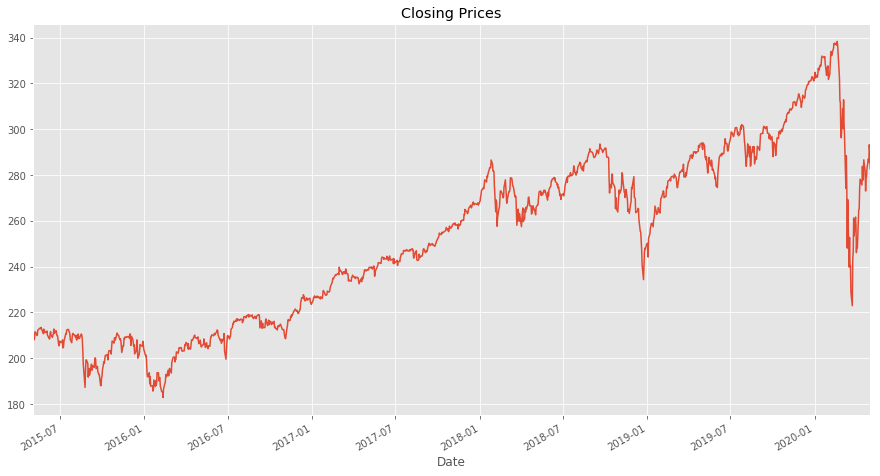

In [31]:
df.Close.plot(figsize=(15,8), title='Closing Prices');

## Detrending

### Differencing the Data

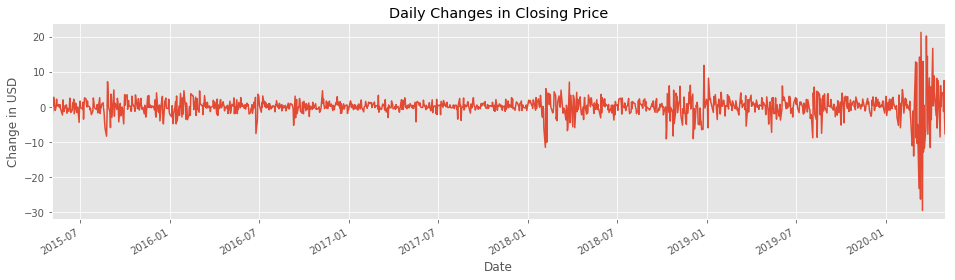

Testing for Stationarity
	P-value: 1.772033572472832e-18


In [33]:
# Differencing
df_diff = df.Close.diff(1).dropna()

# Plotting
df_diff.plot(figsize=(16,4), title="Daily Changes in Closing Price")
plt.ylabel("Change in USD")
plt.show()

# Stationarity Testing
results = adfuller(df_diff)
print(f"Testing for Stationarity\n\tP-value: {results[1]}")

### PACF and ACF

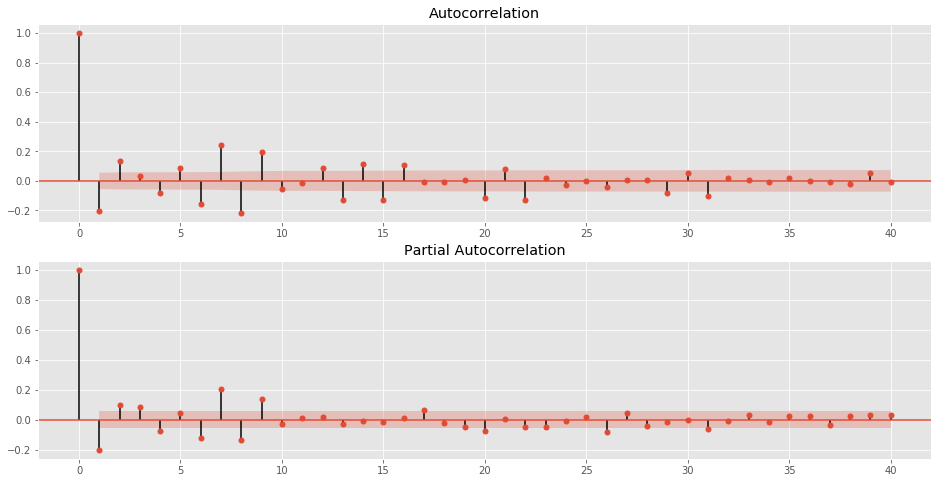

In [34]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(df_diff, ax=ax1, lags=40)
plot_pacf(df_diff, ax=ax2, lags=40)
plt.show()

## Modeling

### Scaling

In [40]:
# Scaler
scaler = MinMaxScaler()

# Creating a new DF
df = pd.DataFrame(scaler.fit_transform(df),
                  index=df.index,
                  columns=df.columns)

df

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Close,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-04,0.183046,0.069099,0.629019,0.170076,0.850791,0.527923,0.588844,0.509472,0.000224,0.000000,...,0.474058,0.239132,0.222890,0.239132,0.727126,0.151166,0.539748,0.000000,0.571947,0.183046
2015-05-05,0.167481,0.059910,0.602436,0.000000,0.756316,0.507912,0.509732,0.493975,0.000224,0.000000,...,0.474058,0.051671,0.127080,0.051671,0.727126,0.134490,0.539748,0.590165,0.515101,0.167481
2015-05-06,0.161950,0.057503,0.570755,0.180824,0.764096,0.504633,0.503250,0.634883,0.000224,0.000000,...,0.474058,0.243345,0.160452,0.243345,0.727126,0.128564,0.539748,0.619621,0.551587,0.161950
2015-05-07,0.167288,0.061194,0.591455,0.343248,0.780086,0.529178,0.533435,0.656651,0.001340,0.000000,...,0.474058,0.401140,0.215653,0.401140,0.727126,0.134283,0.539748,0.652175,0.591598,0.167288
2015-05-08,0.184976,0.069214,0.628019,0.528327,0.811282,0.539198,0.558431,0.691066,0.001340,0.000000,...,0.474058,0.923953,0.512864,0.923953,0.727126,0.153233,0.539748,0.689026,0.636503,0.184976
2015-05-11,0.178480,0.063123,0.610260,0.453770,0.813163,0.526743,0.563581,0.681653,0.000000,0.000000,...,0.474058,0.731939,0.679341,0.731939,0.723911,0.146274,0.539748,0.616987,0.548336,0.178480
2015-05-12,0.174428,0.067040,0.582175,0.516926,0.814827,0.512883,0.557881,0.649850,0.000000,0.000000,...,0.474058,0.612166,0.751244,0.612166,0.723713,0.141932,0.539748,0.624141,0.557162,0.174428
2015-05-13,0.174685,0.061590,0.604382,0.469796,0.820151,0.535502,0.566585,0.654855,0.000053,0.000000,...,0.474058,0.619773,0.647601,0.619773,0.728057,0.142208,0.539748,0.636919,0.572888,0.174685
2015-05-14,0.188770,0.069089,0.626885,0.547385,0.834867,0.537382,0.574042,0.672779,0.000053,0.000000,...,0.474058,0.980216,0.732196,0.980216,0.733446,0.157299,0.539748,0.678029,0.623145,0.188770


### Splitting
Training and Testing

In [35]:
# Splitting 80/20
index = round(len(df)*.80)

# Train and Test
train = df.iloc[:index]

test = df.iloc[index:]

### Training and Fitting

In [37]:
train

,Close,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-04,211.320007,-3.700527e+07,70927200,-0.521736,0.000000e+00,0.000000,0.000000,-1.135894e+07,1000.000000,0.000000,...,50.000000,23.913204,23.913204,-76.086796,0.000000,211.320007,0.000000,-15.841173,0.000000,0.000000
2015-05-05,208.899994,-1.362178e+08,-42399000,-0.739296,-2.742509e+08,-3.529171,-3.529171,-1.253350e+07,1000.000000,0.000000,...,50.000000,5.167100,14.540152,-94.832900,0.000000,208.899994,0.000000,-1.145189,-1.151797,-1.145189
2015-05-06,208.039993,-1.622074e+08,-177459200,-0.507988,-2.516653e+08,-4.107443,-3.818307,-1.853816e+06,1000.000000,0.000000,...,50.000000,24.334521,17.804942,-75.665479,0.000000,208.039993,0.000000,-0.411681,-0.412530,-1.552155
2015-05-07,208.869995,-1.223558e+08,-89214300,-0.300217,-2.052498e+08,0.221338,-2.471759,-2.039526e+05,1003.989627,0.000000,...,50.000000,40.114000,23.205207,-59.886000,0.000000,208.869995,0.000000,0.398963,0.398169,-1.159385
2015-05-08,211.619995,-3.575890e+07,66663000,-0.063466,-1.146909e+08,1.988488,-1.356697,2.404358e+06,1003.989627,0.000000,...,50.000000,92.395279,52.281267,-7.604721,0.000000,211.619995,0.000000,1.316608,1.308016,0.141959
2015-05-11,210.610001,-1.015202e+08,-9045100,-0.158838,-1.092300e+08,-0.208098,-1.126977,1.690963e+06,999.197908,0.000000,...,50.000000,73.193905,68.567728,-26.806095,-0.279501,210.610001,0.000000,-0.477268,-0.478410,-0.335986
2015-05-12,209.979996,-5.922909e+07,-128772700,-0.078049,-1.044013e+08,-2.652537,-1.381237,-7.194757e+05,999.197908,0.000000,...,50.000000,61.216644,75.601943,-38.783356,-0.296715,209.979996,0.000000,-0.299133,-0.299582,-0.634115
2015-05-13,210.020004,-1.180767e+08,-34104800,-0.138338,-8.894574e+07,1.336674,-0.992964,-3.401080e+05,999.388288,0.000000,...,50.000000,61.977251,65.462600,-38.022749,0.081001,210.020004,0.000000,0.019053,0.019051,-0.615182
2015-05-14,212.210007,-3.711113e+07,61829200,-0.039086,-4.622553e+07,1.668185,-0.660321,1.018398e+06,999.388288,0.000000,...,50.000000,98.021587,73.738494,-1.978413,0.549556,212.210007,0.000000,1.042759,1.037360,0.421162


In [36]:
model = VARMAX(train, order=(1,0))

output = model.fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


LinAlgError: Matrix is not positive definite